In [1]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

tf.compat.v1.disable_eager_execution()

from energyflow.archs.dnn import DNN
from energyflow.datasets import qg_nsubs
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2023-08-29 10:35:42.323013: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 10:35:42.355742: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 10:35:42.514682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 10:35:42.515513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 10:35:43.343486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Num GPUs Available:  0
GPUs Available:  []


/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:30: UserWarning: could not import some architectures - cannot import name 'cnn' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))
/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py:40: UserWarning: could not import some architectures - cannot import name 'linear' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Research/MomentAnalysis/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))


In [5]:



# Parameters 
train = 650000
val = 50000
test = 50000
k_order = 1

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


Ls = []
j = max_L
while j >= 1:
    Ls.append(j)
    j = j / 2

num_samples = len(Ls)


# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.005

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs

    l_list = []

    for n in range(8 + 1):

        l_list.append(np.sum(zs * np.power(ls, n)))
    


    return np.array(l_list)



def cumulants(x):

    x[4,:] = np.nan_to_num(np.power(x[4,:] - 4*x[3,:]*x[1,:] - 3*x[2,:]**2 + 12*x[2,:]*x[1,:]**2 - 6*x[1,:]**4, 1))
    x[3,:] = np.nan_to_num(np.power(x[3,:] - 3*x[2,:]*x[1,:] + 2*x[1,:]**3, 1))
    x[2,:] = np.nan_to_num(np.power(x[2,:] - x[1,:]**2, 1))

    return x

# Data 
X, Y = qg_jets.load(train+val+test)

print("Data loaded!")


X = X[:,:,:3].astype(np.float32)
Y2 = to_categorical(Y, num_classes=2)
features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append((log_features(x)))

features = cumulants(np.array(features))





Data loaded!


/tmp/ipykernel_21314/2828513698.py:72: RuntimeWarning: invalid value encountered in power
  x[4,:] = np.nan_to_num(np.power(x[4,:] - 4*x[3,:]*x[1,:] - 3*x[2,:]**2 + 12*x[2,:]*x[1,:]**2 - 6*x[1,:]**4, 0.25))
/tmp/ipykernel_21314/2828513698.py:74: RuntimeWarning: invalid value encountered in power
  x[2,:] = np.nan_to_num(np.power(x[2,:] - x[1,:]**2, 0.5))


In [6]:
rocs = []
for k_order in [1, 2, 3, 4]:


    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:k_order+1], Y2, val=val, test=test)

    dense_sizes = (1,)

    dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')

    # train model
    dnn.fit(X_train, Y_train,
            epochs=50,
            batch_size=500,
            validation_data=(X_val, Y_val),
            verbose=1)

    # get predictions on test data
    preds = dnn.predict(X_test, batch_size=1000)
    dnn.save_weights(f"Data/dnn/linear_O{k_order}.keras")


    # get ROC curve if we have sklearn
    if roc_curve:
        rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

        # get area under the ROC curve
        auc = roc_auc_score(Y_test[:,1], preds[:,1])
        print()
        print('AUC:', auc)
        print()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 1)                 3         
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
 output (Dense)              (None, 2)                 4         
                                                                 
 activation_3 (Activation)   (None, 2)                 0         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Train on 650000 samples, validate on 50000 samples
Epoch 1/50
 27

2023-08-29 10:41:19.961465: W tensorflow/c/c_api.cc:300] Operation '{name:'output_1/bias/Assign' id:457 op device:{requested: '', assigned: ''} def:{{{node output_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_1/bias, output_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.7400 - auc_1: 0.4882 - val_loss: 0.6209 - val_auc_1: 0.7253
Epoch 2/50
 86000/650000 [==>...........................] - ETA: 0s - loss: 0.6228 - auc_1: 0.7184

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-29 10:41:20.770336: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_1/mul' id:593 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/activation_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6173 - auc_1: 0.7216 - val_loss: 0.6136 - val_auc_1: 0.7248
Epoch 3/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6165 - auc_1: 0.7221 - val_loss: 0.6137 - val_auc_1: 0.7252
Epoch 4/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6165 - auc_1: 0.7221 - val_loss: 0.6136 - val_auc_1: 0.7258
Epoch 5/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6165 - auc_1: 0.7222 - val_loss: 0.6136 - val_auc_1: 0.7256
Epoch 6/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6165 - auc_1: 0.7221 - val_loss: 0.6136 - val_auc_1: 0.7258
Epoch 7/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6165 - auc_1: 0.7221 - val_loss: 0.6136 - val_auc_1: 0.7260
Epoch 8/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6165 - auc_1: 0.7221 - val_loss: 0.6136 - val_auc_1: 0.7255
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-29 10:41:58.878954: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_3/Softmax' id:463 op device:{requested: '', assigned: ''} def:{{{node activation_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 650000 samples, validate on 50000 samples
Epoch 1/50
 78000/650000 [==>...........................] - ETA: 1s - loss: 0.6475 - auc_2: 0.7220

2023-08-29 10:41:59.142805: W tensorflow/c/c_api.cc:300] Operation '{name:'training_4/Adam/beta_1/Assign' id:1047 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/beta_1, training_4/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6151 - auc_2: 0.7222 - val_loss: 0.6094 - val_auc_2: 0.7242
Epoch 2/50
 90000/650000 [===>..........................] - ETA: 0s - loss: 0.6087 - auc_2: 0.7252

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-29 10:41:59.927914: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_2/mul' id:984 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/activation_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6092 - auc_2: 0.7241 - val_loss: 0.6093 - val_auc_2: 0.7241
Epoch 3/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6092 - auc_2: 0.7242 - val_loss: 0.6094 - val_auc_2: 0.7230
Epoch 4/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6092 - auc_2: 0.7242 - val_loss: 0.6093 - val_auc_2: 0.7239
Epoch 5/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6092 - auc_2: 0.7242 - val_loss: 0.6093 - val_auc_2: 0.7234
Epoch 6/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6092 - auc_2: 0.7241 - val_loss: 0.6094 - val_auc_2: 0.7238
Epoch 7/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6092 - auc_2: 0.7241 - val_loss: 0.6094 - val_auc_2: 0.7242
Epoch 8/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6092 - auc_2: 0.7241 - val_loss: 0.6094 - val_auc_2: 0.7244
Epo

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-29 10:42:37.764923: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_5/Softmax' id:854 op device:{requested: '', assigned: ''} def:{{{node activation_5/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 650000 samples, validate on 50000 samples
Epoch 1/50
 78000/650000 [==>...........................] - ETA: 1s - loss: 0.6401 - auc_3: 0.6721

2023-08-29 10:42:38.044061: W tensorflow/c/c_api.cc:300] Operation '{name:'output_3/kernel/Assign' id:1234 op device:{requested: '', assigned: ''} def:{{{node output_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_3/kernel, output_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6139 - auc_3: 0.7181 - val_loss: 0.6049 - val_auc_3: 0.7278
Epoch 2/50
 78000/650000 [==>...........................] - ETA: 0s - loss: 0.6086 - auc_3: 0.7230

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-29 10:42:38.908995: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_3/mul' id:1375 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/activation_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 1s 1us/sample - loss: 0.6075 - auc_3: 0.7240 - val_loss: 0.6047 - val_auc_3: 0.7274
Epoch 3/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6075 - auc_3: 0.7237 - val_loss: 0.6046 - val_auc_3: 0.7270
Epoch 4/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6074 - auc_3: 0.7236 - val_loss: 0.6048 - val_auc_3: 0.7262
Epoch 5/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6075 - auc_3: 0.7235 - val_loss: 0.6047 - val_auc_3: 0.7277
Epoch 6/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6074 - auc_3: 0.7235 - val_loss: 0.6047 - val_auc_3: 0.7261
Epoch 7/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6074 - auc_3: 0.7235 - val_loss: 0.6047 - val_auc_3: 0.7270
Epoch 8/50
650000/650000 [==============================] - 1s 1us/sample - loss: 0.6074 - auc_3: 0.7235 - val_loss: 0.6047 - val_auc_3: 0.7263
Epo

KeyboardInterrupt: 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 100)               0   

2023-08-29 09:12:41.047244: W tensorflow/c/c_api.cc:300] Operation '{name:'false_positives_4/Assign' id:2081 op device:{requested: '', assigned: ''} def:{{{node false_positives_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_4, false_positives_4/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-29 09:12:41.090278: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_4/Softmax' id:2184 op device:{requested: '', assigned: ''} def:{{{node


AUC: 0.7318659739522974

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               400       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (Non

/tmp/ipykernel_4090/1657320707.py:40: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rocs[i][1], 1-rocs[i][0], '-', color = colors[i], alpha = 0.5, label = l, lw = 3, ls = "--")
2023-08-29 09:12:41.430700: W tensorflow/c/c_api.cc:300] Operation '{name:'output_5/kernel/Assign' id:2458 op device:{requested: '', assigned: ''} def:{{{node output_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_5/kernel, output_5/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_upd


AUC: 0.7815995063458221

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 4)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               500       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (Non

2023-08-29 09:12:41.794381: W tensorflow/c/c_api.cc:300] Operation '{name:'false_positives_6/Assign' id:2651 op device:{requested: '', assigned: ''} def:{{{node false_positives_6/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_6, false_positives_6/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-29 09:12:41.842756: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_6/Softmax' id:2754 op device:{requested: '', assigned: ''} def:{{{node


AUC: 0.8122950462145436

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               600       
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (Non

2023-08-29 09:12:42.161147: W tensorflow/c/c_api.cc:300] Operation '{name:'output_7/bias/Assign' id:3033 op device:{requested: '', assigned: ''} def:{{{node output_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](output_7/bias, output_7/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-29 09:12:42.214357: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_7/Softmax' id:3039 op device:{requested: '', assigned: ''} def:{{{node activation_7/So


AUC: 0.8263296727842463



/tmp/ipykernel_4090/1657320707.py:40: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(rocs[i][1], 1-rocs[i][0], '-', color = colors[i], alpha = 0.5, label = l, lw = 3, ls = "--")



AUC: 0.831



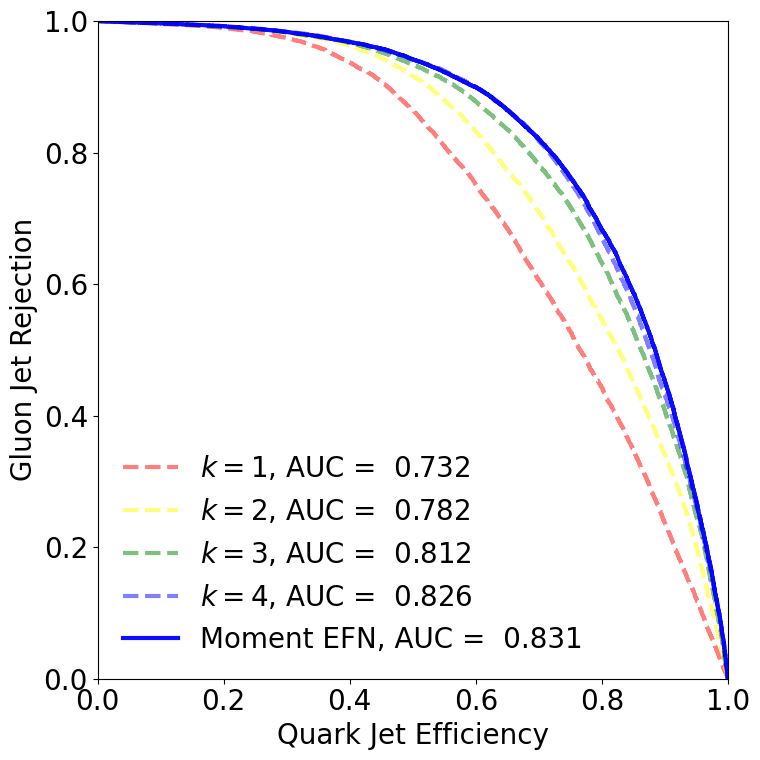

In [ ]:
from energyflow.archs.moment import EFN_moment, PFN_moment

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['font.size'] = '20'

rocs = []
colors = ['red', 'yellow', 'green', 'blue', 'purple', 'pink', "grey", "black"]

for i, k_order in enumerate([1, 2, 3, 4]):


    (X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,:k_order+1], Y2, val=val, test=test)

    dense_sizes = (1)

    dnn = DNN(input_dim=k_order+1, dense_sizes=dense_sizes, metrics = [tf.keras.metrics.AUC()], acts='linear')
    dnn.load_weights(f"Data/dnn/linear_O{k_order}.keras")


    # get predictions on test data
    preds = dnn.predict(X_test, batch_size=1000)


    # get ROC curve if we have sklearn
    rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()

    if False:
        l = "EFN"
    else:
        l = f"$k = {k_order}$, AUC = {auc : .3f}"
    plt.plot(rocs[i][1], 1-rocs[i][0], '-', color = colors[i], alpha = 0.5, label = l, lw = 3, ls = "--")


# ##### Original #####

X, Y = qg_jets.load(train+val+test)
X = X[:,:,:3].astype(np.float32)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

(z_train, z_val, z_test,
p_train, p_val, p_test,
Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

X_train = [z_train, p_train]
X_val = [z_val, p_val]
X_test = [z_test, p_test]

dictionary = {'Phi_mapping_dim' : [2,1],
                                        'output_dim' : 1, 'output_act' : 'sigmoid',
                                        'Phi_sizes' : [100, 100], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" : 1e-6,
                                        'F_sizes' : [100,100,100], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                                        'order' : 4 , 'architecture_type':'moment',
                                        'loss': 'binary_crossentropy',}
# moment_efn = EFN_moment(**dictionary, summary=False)



# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))


# # moment_efn.load_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras", by_name=True)
# for layer in moment_efn.layers:
#     if  len(layer.get_weights()) > 0 :
#         print(layer.name, np.mean(layer.get_weights()[0]))

# # # initialize
# # moment_efn.fit(X_train, Y_train, epochs = 50)
# # moment_efn.save_weights("Data/qg_EFN_latent/order_4/Models/O4_L1_2Phi100_3F100_0.keras")

# preds = moment_efn.predict(X_test, batch_size=1000)

# print(preds.shape, Y_test.shape)

# get ROC curve if we have sklearn
rocs.append(np.load("roc.npy"))
# np.save("roc", roc_curve(Y_test, preds))

# get area under the ROC curve
auc = 0.831 #roc_auc_score(Y_test, preds)
print()
print('AUC:', auc)
print()


plt.plot(rocs[-1][1], (1-rocs[-1][0]) , '-', color = "blue", alpha = 0.95, label = f"Moment EFN, AUC = {auc: .3f}", lw = 3)





# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)


plt.savefig("Plots/analytic_auc.pdf")
plt.show()




In [ ]:



# Parameters 
val = 5000
test = 5000
k_order = 4

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


Ls = []
j = max_L
while j >= 1:
    Ls.append(j)
    j = j / 2

num_samples = len(Ls)


# max_L_per_order = [2**(8-k_order),]
# F_min, F_max = 100
# Phi_min, Phi_max = 100
# logN_max = 6.5

def log_features(x):


    a = 1
    b = 0.5
    c = 0.01

    zs = x[:,0]
    
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    ls = np.power(rs, 0.25)
    
    l0 = 1.0
    l1 = np.sum(zs * ls**1)
    l2 = np.sum(zs * ls**2)
    l3 = np.sum(zs * ls**3)
    l4 = np.sum(zs * ls**4)

    return (l0, l1, l2, l3, l4)



X, Y = qg_jets.load(train+val+test)
Y = to_categorical(Y, num_classes=2)
print("Data loaded!")


features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append(log_features(x))

features = np.array(features)
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(np.array(features), Y, val=val, test=test)




Data loaded!


In [ ]:

dense_sizes = (100, 100, 100)

dnn = DNN(input_dim=4+1, dense_sizes=dense_sizes)

# train model
dnn.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = dnn.predict(X_test, batch_size=1000)

angularity_rocs = []
# get ROC curve if we have sklearn
if roc_curve:
    angularity_rocs.append(roc_curve(Y_test[:,1], preds[:,1]))

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('AUC:', auc)
    print()



Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               600       
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_9 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 activation_10 (Activation)  (None, 100)               0   

2023-08-29 09:14:01.420832: W tensorflow/c/c_api.cc:300] Operation '{name:'training_8/Adam/output_8/kernel/m/Assign' id:3506 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/output_8/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/output_8/kernel/m, training_8/Adam/output_8/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 5us/sample - loss: 0.5838 - acc: 0.6834 - val_loss: 0.5756 - val_acc: 0.7080
Epoch 2/50
 26000/650000 [>.............................] - ETA: 2s - loss: 0.5747 - acc: 0.6906

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-08-29 09:14:04.585405: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_8/mul' id:3380 op device:{requested: '', assigned: ''} def:{{{node loss_8/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_8/mul/x, loss_8/activation_11_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


650000/650000 [==============================] - 3s 5us/sample - loss: 0.5684 - acc: 0.6990 - val_loss: 0.5635 - val_acc: 0.7130
Epoch 3/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5629 - acc: 0.7043 - val_loss: 0.5591 - val_acc: 0.7196
Epoch 4/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5620 - acc: 0.7048 - val_loss: 0.5581 - val_acc: 0.7188
Epoch 5/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5603 - acc: 0.7062 - val_loss: 0.5563 - val_acc: 0.7226
Epoch 6/50
650000/650000 [==============================] - 3s 4us/sample - loss: 0.5602 - acc: 0.7063 - val_loss: 0.5580 - val_acc: 0.7194
Epoch 7/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5597 - acc: 0.7065 - val_loss: 0.5582 - val_acc: 0.7150
Epoch 8/50
650000/650000 [==============================] - 3s 5us/sample - loss: 0.5593 - acc: 0.7072 - val_loss: 0.5552 - val_acc: 0.7232
Epoch 9/50
650000/650000 [=====

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-29 09:16:34.603721: W tensorflow/c/c_api.cc:300] Operation '{name:'activation_11/Softmax' id:3304 op device:{requested: '', assigned: ''} def:{{{node activation_11/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](output_8/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


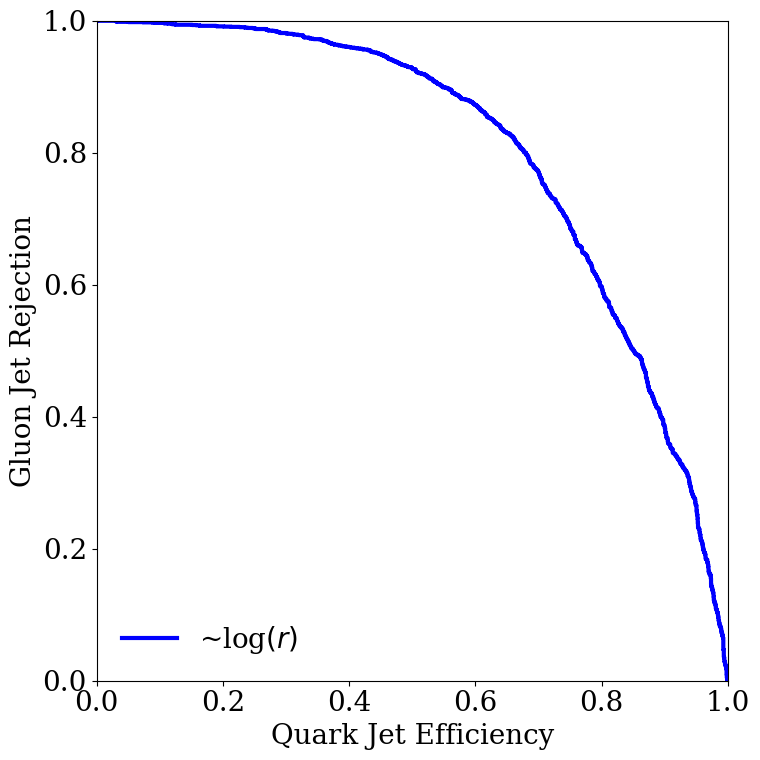

In [ ]:
# some nicer plot settings 
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.autolayout'] = True

# iterate over the ROC curves and plot them
labels = ["~log$(r)$", "Angularities"]
colors = ["blue", "black"]
for i in range(len(angularity_rocs)):
    plt.plot(angularity_rocs[i][1], 1-angularity_rocs[i][0], '-', label = labels[i], lw = 3, color = colors[i])

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()